In [1]:
%matplotlib inline

In [22]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time
import multiprocessing

In [3]:
%cd ../
import CythonDTW
import TSM_Import

/mnt/c/Users/Daniel Yang/Desktop/Final_Project


# Import Data

In [4]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

## Feature Extraction

In [5]:
def getChromaFeatures(audio):
  chroma = lb.feature.chroma_stft(audio, norm=2)
  return chroma

## Segmental DTW

In [6]:
def getCostMatrices(queries, ref):
  cost_matrices = []
  for query_chroma in queries:
    cost_matrices.append(sspat.distance.cdist(query_chroma.T, ref.T, metric='cosine'))
  return cost_matrices


In [7]:
def getAccumCostMatrix(cost_matrix):
  steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
  weights = [2,1,1]
  D = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, metric = 'cosine', subseq=True, backtrack=False)
  return D

In [8]:
def generateSegmentCostMatrix(costMatrices):
  frame_cost_matrix = []
  for D in costMatrices:
    cost = D[-1,:]
    frame_cost_matrix.append(cost)
  return frame_cost_matrix

In [9]:
def segmental_DTW(segmentCostMatrix, segment_lengths):
  steps = [[0,1]]
  weights = [0]
  D, path = CythonDTW.globalDTW(segmentCostMatrix, steps, weights, segment_lengths)

  return D, path

In [10]:
def getPathEnds(global_path):
  endpoints = []
  for idx in range(1,len(global_path)):
    if global_path[idx][0]!=global_path[idx-1][0]:
      endpoints.append(global_path[idx])
  endpoints.insert(0,global_path[0])
  return endpoints


## TSM

### Other

In [11]:
def extrapolateTimeStretchFunction(local_paths, N):
  new_stretch = []
  k = 0
  slope = 1
  new_time = 0
  counter = 0
  for i in range(0,N):
    if k<len(local_paths) and i >= local_paths[k][0][1]*512 and i <= local_paths[k][-1][1]*512:
      path = local_paths[k]
      if i == path[-1][1]*512:
        k+=1
        slope=1
        counter = 0
      elif i == path[counter][1]*512:
        slope = (path[counter+1][1]-path[counter][1])/(path[counter+1][0]-path[counter][0])
        counter+=1
    else:
      slope=1
    new_time+=slope
    new_stretch.append(int(new_time))
  return new_stretch

In [12]:
def getInverseTimeFunction(time_function):
  inverse_function = []
  counter = 0
  for i in range(time_function[-1]+1):
    while time_function[counter]<i:
      counter+=1
    inverse_function.append(counter)
  return inverse_function

## Process Queries

In [28]:
def writeToFile(tf, segment_predict, solo_name, ref_name, hypdir, time_taken):
    print(hypdir)
    if hypdir != None:
        experiment = "experiments/{}".format(hypdir)
        if not os.path.exists(experiment):
            os.mkdir(experiment)
        fname = "experiments/{}/{}-{}.hyp".format(hypdir,solo_name,ref_name)
        with open (fname, 'wb') as f:
            pkl.dump((solo_name, ref_name, tf, segment_predict, time_taken),f)

In [29]:
def processQuery(solo_name, ref_name, sr=22050, visualize=False, hypdir = None):
  print("Processing solo {}, Accompaniment {}".format(solo_name, ref_name))
  warnings.filterwarnings("ignore", category=DeprecationWarning)
  start_time = time.time()

  solo_segments = audioFiles[solo_name]
  ref_audio = audioFiles[ref_name]

  # Calculate L2-Normalized Chromas
  solo_chromas = []
  segment_lengths = []
  ref_chroma = getChromaFeatures(ref_audio)
  for i in solo_segments:
    solo_chromas.append(getChromaFeatures(i))
    segment_lengths.append(solo_chromas[-1].shape[1])

  # Frame-Level DTW
  frame_costs = []
  cost_matrices = getCostMatrices(solo_chromas, ref_chroma)
  

  accum_costs = []
  for C in cost_matrices:
    D = getAccumCostMatrix(C)
    accum_costs.append(D)
  
  # Segment-Level DTW
  segment_cost = np.array(generateSegmentCostMatrix(accum_costs))
  D, path = segmental_DTW(segment_cost, segment_lengths)
  pathEnds = getPathEnds(path)[::-1]
  if visualize:
      lbd.specshow(D, x_axis='frames', y_axis='frames')
      x = [i[0] for i in path]
      y = [i[1] for i in path]
      plt.plot(y, x, label='Optimal path', color='y')
      keys = queryInfo['p1s']
      samples = []
      for idx,key in enumerate(keys):
          i = key.split(',')[1][:-1]
          plot_time = timeData['p1f_perf16'][i]
          sample = np.round(plot_time*sr/512)
          plt.plot(int(sample), idx, marker=".", markersize=16)


        
  # Local Backtraces
  local_paths = []
  segment_predict = []
  for idx, C in enumerate(cost_matrices):
    local_path = list(CythonDTW.local_backtrace(accum_costs[idx],C,pathEnds[idx][1]))[::-1]
    local_paths.append(local_path)
    segment_predict.append((local_path[0][1],pathEnds[idx][1]))
    # if idx==0:
    #   lbd.specshow(accum_costs[idx], x_axis='frames', y_axis='frames')
    #   x = [i[0] for i in local_path]
    #   y = [i[1] for i in local_path]
    #   plt.plot(y,x, label='Optimal path', color='y')

    
  
  # TSM

  time_function = extrapolateTimeStretchFunction(local_paths, len(ref_audio))
  time_taken = time.time()-start_time
  print("Took {} seconds".format(time_taken))
  writeToFile(time_function, segment_predict, solo_name, ref_name, hypdir, time_taken)
  return time_function


In [ ]:
solo_name, ref_name = 'p1s_perf25', 'p1f_perf16'
time_function = processQuery(solo_name, ref_name, visualize=True, hypdir="debug")

Processing solo p1s_perf25, Accompaniment p1f_perf16


In [ ]:
# Process all queries
multiprocess = False
hypdir = "debug"
solo = {}
accompaniment = {}
for fileId in fileIds:
    pieceNum = fileId.split("_")[0]
    if 's' in fileId:
        if not pieceNum in solo.keys():
            solo[pieceNum] = [fileId]
        else:
            solo[pieceNum].append(fileId)
    if 'f' in fileId:
        if not pieceNum in accompaniment.keys():
            accompaniment[pieceNum] = [fileId]
        else:
            accompaniment[pieceNum].append(fileId)
inputs = []
for piece in solo.keys():
    soloPieces = solo[piece]
    refPieces = accompaniment[piece[:-1]+'f']
    for i in soloPieces:
        for j in refPieces:
            inputs.append([i,j,False, hypdir])

if multiprocess: 
    n_cores = multiprocessing.cpu_count()-1
    pool = multiprocessing.Pool(processes=n_cores)
    outputs = list(pool.starmap(processQuery, inputs))
else:
    for i in inputs:
        processQuery(i[0], i[1], i[2], i[3])

## Analysis

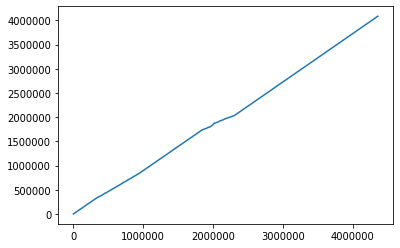

In [17]:
inverse_tf = getInverseTimeFunction(time_function)
plt.plot(inverse_tf)

In [30]:
ref_audio = audioFiles['p1f_perf23']
new_audio = TSM_Import.phase_vocoder(ref_audio,inverse_tf)

/mnt/c/Users/Daniel Yang/Desktop/Final_Project/src/TSM_Import.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrogram[:,index]= spec


w nom (1025, 1) hop (7591,) S (1025, 7591) analysis_instances (7592,) S[0] (7591,)


In [31]:
ipd.Audio(ref_audio, rate = sr)

NameError: name 'sr' is not defined

In [ ]:
ipd.Audio(new_audio, rate = sr)